## Spark Developer Training

**Manaranjan Pradhan**<br/>
**manaranjan@enablecloud.com**<br/>
*This notebook is given as part of Spark Training to Participants. Forwarding others is strictly prohibited.*

# Lab: Retail Data Analysis

** Data Source **
* Online Retail Store Dataset
* Type: CSV files

**Technical Accomplishments:**
* Cleaning Data
* Creating New Columns from existing columns
* Storing Data in Parquet/Columnar Format
* Aggregations
* Collecting Data into Pandas Dataframes
* Creating Dashboards using inbuilt plots or matplotlib/seaborn plots
* Rollups, cubes or grouping sets

This data uses the **Online Retail** data set.

The dataset is a csv file and contains retail transaction records. The details of the fields are as below:

- InvoiceNo: Transaction ID. (Type: Integer)
- StockCode: Product Code. (Type: String)
- Description: Product Description. (Type: String)
- Quantity: No of units of the product bought by the customer in this transaction. (Type: Integer)
- InvoiceDate: Date of the transaction. (Type: String) Need to be converted to timestamp later.
- UnitPrice: Price for each unit of the product. (Type: Double)
- CustomerID: Customer ID. (Type: Integer)
- Country: Country name from where the transaction was executed. (Type: String)

Upload the file onto the DBFS location: **/FileStore/tables/retail/online_retail_csv.zip**.

In [0]:
%fs ls dbfs:/databricks-datasets/online_retail/data-001/

path,name,size
dbfs:/databricks-datasets/online_retail/data-001/data.csv,data.csv,5357240


In [0]:
%python 

from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
from pyspark.sql.functions import col

# The directory containing our csv files.
inputPath = "dbfs:/databricks-datasets/online_retail/data-001/data.csv"

# Define the schema for the dataset
inputSchema = StructType([StructField("InvoiceNo", IntegerType(), True),
                          StructField("StockCode", StringType(), True),
                          StructField("Description", StringType(), True),
                          StructField("Quantity", IntegerType(), True),
                          StructField("InvoiceDate", StringType(), True),
                          StructField("UnitPrice", DoubleType(), True),
                          StructField("CustomerID", IntegerType(), True),
                          StructField("Country", StringType(), True)])

# Read into the dataframe
retailsDF = (spark.read 
            .option("header", "True")
            .schema(inputSchema)  
            .csv(inputPath))

In [0]:
retailsDF.show()

+---------+---------+--------------------+--------+------------+---------+----------+--------------+
InvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
 536365| 85123A|WHITE HANGING HEA...| 6|12/1/10 8:26| 2.55| 17850|United Kingdom|
 536365| 71053| WHITE METAL LANTERN| 6|12/1/10 8:26| 3.39| 17850|United Kingdom|
 536365| 84406B|CREAM CUPID HEART...| 8|12/1/10 8:26| 2.75| 17850|United Kingdom|
 536365| 84029G|KNITTED UNION FLA...| 6|12/1/10 8:26| 3.39| 17850|United Kingdom|
 536365| 84029E|RED WOOLLY HOTTIE...| 6|12/1/10 8:26| 3.39| 17850|United Kingdom|
 536365| 22752|SET 7 BABUSHKA NE...| 2|12/1/10 8:26| 7.65| 17850|United Kingdom|
 536365| 21730|GLASS STAR FROSTE...| 6|12/1/10 8:26| 4.25| 17850|United Kingdom|
 536366| 22633|HAND WARMER UNION...| 6|12/1/10 8:28| 1.85| 17850|United Kingdom|
 536366| 22632|HAND WARMER RED P...| 6|12/1/10 8:28| 1.85| 17850|United Kingdom|
 536367| 84879|ASSORTED COLOUR B...| 32|12/1/10 8:34| 1.69| 13047|United Kingdom|
 536367| 22745|POPPY'S PLAYHOUSE...| 6|12/1/10 8:34| 2.1| 13047|United Kingdom|
 536367| 22748|POPPY'S PLAYHOUSE...| 6|12/1/10 8:34| 2.1| 13047|United Kingdom|
 536367| 22749|FELTCRAFT PRINCES...| 8|12/1/10 8:34| 3.75| 13047|United Kingdom|
 536367| 22310|IVORY KNITTED MUG...| 6|12/1/10 8:34| 1.65| 13047|United Kingdom|
 536367| 84969|BOX OF 6 ASSORTED...| 6|12/1/10 8:34| 4.25| 13047|United Kingdom|
 536367| 22623|BOX OF VINTAGE JI...| 3|12/1/10 8:34| 4.95| 13047|United Kingdom|
 536367| 22622|BOX OF VINTAGE AL...| 2|12/1/10 8:34| 9.95| 13047|United Kingdom|
 536367| 21754|HOME BUILDING BLO...| 3|12/1/10 8:34| 5.95| 13047|United Kingdom|
 536367| 21755|LOVE BUILDING BLO...| 3|12/1/10 8:34| 5.95| 13047|United Kingdom|
 536367| 21777|RECIPE BOX WITH M...| 4|12/1/10 8:34| 7.95| 13047|United Kingdom|
+---------+---------+--------------------+--------+------------+---------+----------+--------------+
only showing top 20 rows

##![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) Data Preparation

For our analysis, we need to prepare the dataset. This will invove some cleanup and deriving new columns.

- Compute Total value (TotalPrice) of each transaction by multiplying unit price with quantity
- Convert InvoiceDate to timestamp
- Derive year and month column from InvoiceDate column

In [0]:
%python

from pyspark.sql.functions import unix_timestamp, format_number, col, year, month

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

newRetailsDF = (retailsDF
                    .withColumn("InvoiceDate", unix_timestamp(col("InvoiceDate"), "MM/dd/yy HH:mm").cast("timestamp"))
                    .withColumn("TotalPrice", format_number(col("UnitPrice") * col("Quantity"), 2).cast("double"))
                    .withColumn("Year", year(col("InvoiceDate")))
                    .withColumn("Month", month(col("InvoiceDate"))))

In [0]:
newRetailsDF.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+----------+----+-----+
InvoiceNo|StockCode| Description|Quantity| InvoiceDate|UnitPrice|CustomerID| Country|TotalPrice|Year|Month|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+----------+----+-----+
 536365| 85123A|WHITE HANGING HEA...| 6|2010-12-01 08:26:00| 2.55| 17850|United Kingdom| 15.3|2010| 12|
 536365| 71053| WHITE METAL LANTERN| 6|2010-12-01 08:26:00| 3.39| 17850|United Kingdom| 20.34|2010| 12|
 536365| 84406B|CREAM CUPID HEART...| 8|2010-12-01 08:26:00| 2.75| 17850|United Kingdom| 22.0|2010| 12|
 536365| 84029G|KNITTED UNION FLA...| 6|2010-12-01 08:26:00| 3.39| 17850|United Kingdom| 20.34|2010| 12|
 536365| 84029E|RED WOOLLY HOTTIE...| 6|2010-12-01 08:26:00| 3.39| 17850|United Kingdom| 20.34|2010| 12|
 536365| 22752|SET 7 BABUSHKA NE...| 2|2010-12-01 08:26:00| 7.65| 17850|United Kingdom| 15.3|2010| 12|
 536365| 21730|GLASS STAR FROSTE...| 6|2010-12-01 08:26:00| 4.25| 17850|United Kingdom| 25.5|2010| 12|
 536366| 22633|HAND WARMER UNION...| 6|2010-12-01 08:28:00| 1.85| 17850|United Kingdom| 11.1|2010| 12|
 536366| 22632|HAND WARMER RED P...| 6|2010-12-01 08:28:00| 1.85| 17850|United Kingdom| 11.1|2010| 12|
 536367| 84879|ASSORTED COLOUR B...| 32|2010-12-01 08:34:00| 1.69| 13047|United Kingdom| 54.08|2010| 12|
 536367| 22745|POPPY'S PLAYHOUSE...| 6|2010-12-01 08:34:00| 2.1| 13047|United Kingdom| 12.6|2010| 12|
 536367| 22748|POPPY'S PLAYHOUSE...| 6|2010-12-01 08:34:00| 2.1| 13047|United Kingdom| 12.6|2010| 12|
 536367| 22749|FELTCRAFT PRINCES...| 8|2010-12-01 08:34:00| 3.75| 13047|United Kingdom| 30.0|2010| 12|
 536367| 22310|IVORY KNITTED MUG...| 6|2010-12-01 08:34:00| 1.65| 13047|United Kingdom| 9.9|2010| 12|
 536367| 84969|BOX OF 6 ASSORTED...| 6|2010-12-01 08:34:00| 4.25| 13047|United Kingdom| 25.5|2010| 12|
 536367| 22623|BOX OF VINTAGE JI...| 3|2010-12-01 08:34:00| 4.95| 13047|United Kingdom| 14.85|2010| 12|
 536367| 22622|BOX OF VINTAGE AL...| 2|2010-12-01 08:34:00| 9.95| 13047|United Kingdom| 19.9|2010| 12|
 536367| 21754|HOME BUILDING BLO...| 3|2010-12-01 08:34:00| 5.95| 13047|United Kingdom| 17.85|2010| 12|
 536367| 21755|LOVE BUILDING BLO...| 3|2010-12-01 08:34:00| 5.95| 13047|United Kingdom| 17.85|2010| 12|
 536367| 21777|RECIPE BOX WITH M...| 4|2010-12-01 08:34:00| 7.95| 13047|United Kingdom| 31.8|2010| 12|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+----------+----+-----+
only showing top 20 rows

#### Finding total number of records

In [0]:
%python 

newRetailsDF.count()

Out[5]: 65499

There are 65499 records available in the dataset.

### Finding and removing null values from the columns

Are there any null values in *TotalPrice* Column? 

- Find out how many such records exist?
- Remove the records to create a cleaned dataset.

In [0]:
%python

newRetailsDF.filter(newRetailsDF["TotalPrice"].isNull()).count()

Out[6]: 67

About 67 records contain null values in the *TotalPrice* column. We will filter only the cleaned records into a resulting dataframe *cleanedRetailsDF*.

- Null values in all the columns

In [0]:
{col: newRetailsDF.filter(newRetailsDF[col].isNull()).count() for col in newRetailsDF.columns}

Out[7]: {'InvoiceNo': 1084,
 'StockCode': 0,
 'Description': 166,
 'Quantity': 0,
 'InvoiceDate': 0,
 'UnitPrice': 0,
 'CustomerID': 25281,
 'Country': 0,
 'TotalPrice': 67,
 'Year': 0,
 'Month': 0}

In [0]:
%python

cleanedRetailsDF = newRetailsDF.na.drop()

In [0]:
%python

cleanedRetailsDF.cache()
display(newRetailsDF)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01T08:26:00.000+0000,2.55,17850,United Kingdom,15.3,2010,12
536365,71053,WHITE METAL LANTERN,6,2010-12-01T08:26:00.000+0000,3.39,17850,United Kingdom,20.34,2010,12
536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01T08:26:00.000+0000,2.75,17850,United Kingdom,22.0,2010,12
536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01T08:26:00.000+0000,3.39,17850,United Kingdom,20.34,2010,12
536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01T08:26:00.000+0000,3.39,17850,United Kingdom,20.34,2010,12
536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01T08:26:00.000+0000,7.65,17850,United Kingdom,15.3,2010,12
536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01T08:26:00.000+0000,4.25,17850,United Kingdom,25.5,2010,12
536366,22633,HAND WARMER UNION JACK,6,2010-12-01T08:28:00.000+0000,1.85,17850,United Kingdom,11.1,2010,12
536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01T08:28:00.000+0000,1.85,17850,United Kingdom,11.1,2010,12
536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01T08:34:00.000+0000,1.69,13047,United Kingdom,54.08,2010,12


In [0]:
from pyspark.sql.functions import *

In [0]:
cleanedRetailsDF.select(min("TotalPrice"), max("TotalPrice")).show()

+---------------+---------------+
min(TotalPrice)|max(TotalPrice)|
+---------------+---------------+
 0.0| 902.4|
+---------------+---------------+

In [0]:
%sql 

drop table IF EXISTS retailtxns 

In [0]:
cleanedRetailsDF.write.saveAsTable("retailtxns")

### Advanced Options for storing tables or parquet formats

- Store a parquet file into a location. The reader must know the location to read the file back.
<code>
cleanedRetailsDF.write.parquet("/FileStore/tables/mytable/")
</code>

- Store a parquet file as a table. The reader needs to only know the table name.
<code>
cleanedRetailsDF.write.format("parquet").saveAsTable("retailtxns", path = "/FileStore/tables/mytable/", mode='overwrite')
</code>

In [0]:
%sql

describe formatted retailtxns

col_name,data_type,comment
InvoiceNo,int,null
StockCode,string,null
Description,string,null
Quantity,int,null
InvoiceDate,timestamp,null
UnitPrice,double,null
CustomerID,int,null
Country,string,null
TotalPrice,double,null
Year,int,null


### Reading the table

In [0]:
retailtxns_df = spark.read.table("retailtxns")
retailtxns_df.cache()

Out[14]: DataFrame[InvoiceNo: int, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: int, Country: string, TotalPrice: double, Year: int, Month: int]

## Creating Insights

#### Top 10 countries by revenue
- using barplot

In [0]:
reveune_df = retailtxns_df.groupBy("Country").agg(sum("TotalPrice").alias("TotalRevenue"))
top10_countries_df = reveune_df.sort(desc("TotalRevenue")).limit(10)

In [0]:
display(top10_countries_df)

Country,TotalRevenue
United Kingdom,659473.7400000205
Netherlands,27200.859999999993
EIRE,25092.22
Germany,23094.40000000001
France,21943.93
Australia,8645.88
Spain,7615.719999999999
Portugal,5811.749999999998
Switzerland,4909.549999999999
Japan,3910.6699999999996


In [0]:
import matplotlib.pyplot as plt
import seaborn as sn

In [0]:
top10_pd_df = top10_countries_df.toPandas()

Out[19]:

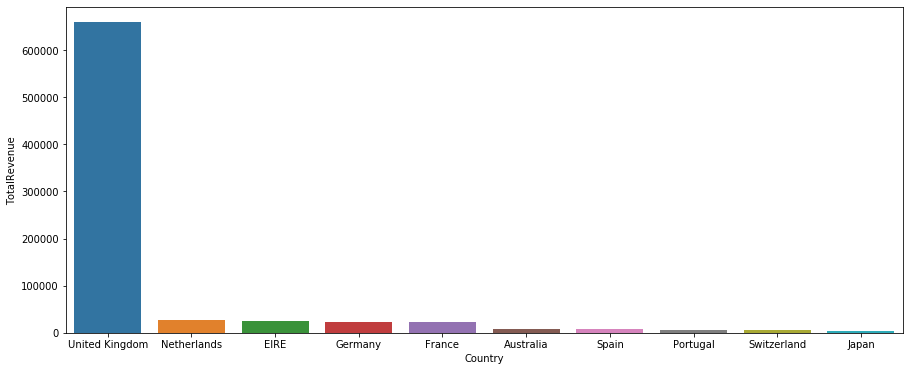

<matplotlib.axes._subplots.AxesSubplot at 0x7f467eb4a390>

In [0]:
plt.figure(figsize= (15, 6 ))
sn.barplot(data = top10_pd_df,
           x = 'Country',
           y = 'TotalRevenue')

#### Distribution of Invoice Values

In [0]:
cust_amount_df = (retailtxns_df
                     .groupBy("CustomerID")
                     .agg(sum("TotalPrice").alias("MValue"),
                         count("InvoiceNo").alias("Frequency")).toPandas())

In [0]:
cust_amount_df.sample(10)

Out[21]:

,CustomerID,MValue,Frequency
851,15180,87.50,6
278,12877,250.26,17
345,15194,1890.54,91
872,13280,307.35,37
451,16722,799.52,41
1126,17602,767.05,103
460,15380,230.10,1
782,13506,301.12,17
393,17220,317.50,32
793,14487,125.10,13


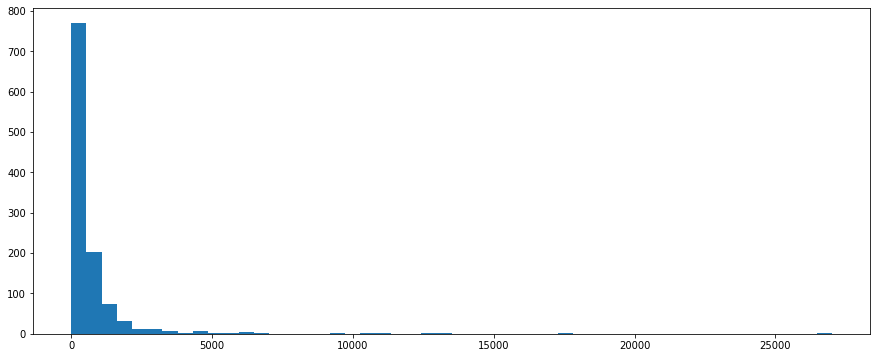

In [0]:
plt.figure(figsize= (15, 6 ))
plt.hist( cust_amount_df.MValue, bins = 50 );

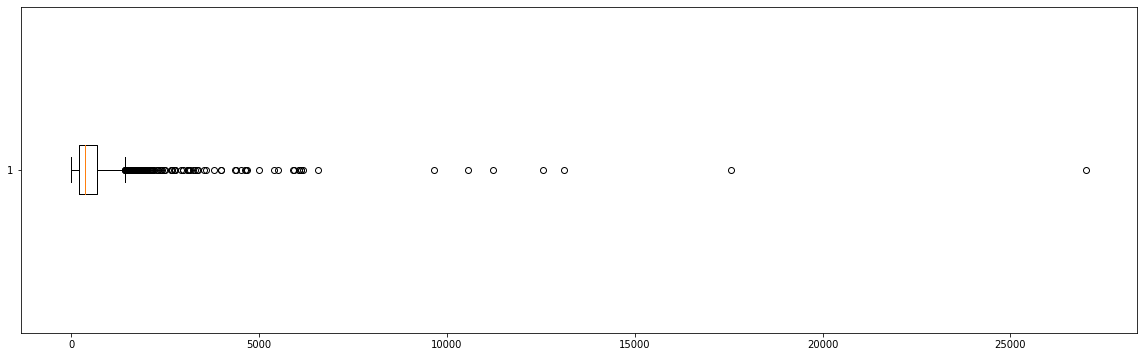

In [0]:
plt.figure(figsize= (20, 6 ))
box = plt.boxplot(cust_amount_df.MValue, vert = False);

In [0]:
box

Out[24]: {'whiskers': [<matplotlib.lines.Line2D at 0x7f467c89e350>,
 <matplotlib.lines.Line2D at 0x7f467c89e910>],
 'caps': [<matplotlib.lines.Line2D at 0x7f467c89ee10>,
 <matplotlib.lines.Line2D at 0x7f467c892750>],
 'boxes': [<matplotlib.lines.Line2D at 0x7f467c892710>],
 'medians': [<matplotlib.lines.Line2D at 0x7f467c8a6890>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f467c8a6d90>],
 'means': []}

In [0]:
box['medians'][0].get_xdata()

Out[25]: array([353.19, 353.19])

In [0]:
[cap.get_xdata()[0] for cap in box['caps']]

Out[26]: [0.85, 1422.4799999999998]

In [0]:
[cap.get_xdata()[0] for cap in box['whiskers']]

Out[27]: [206.045, 693.47]

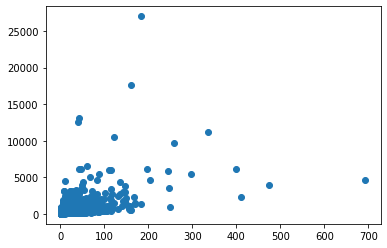

In [0]:
plt.scatter(cust_amount_df.Frequency,
            cust_amount_df.MValue);

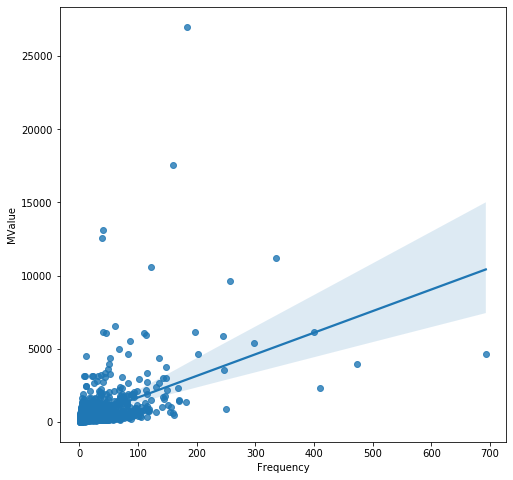

In [0]:
plt.figure(figsize= (8, 8 ))
sn.regplot( data = cust_amount_df,
            x = 'Frequency',
            y = 'MValue' );

### Advanced Grouping Functions

In read world, business may want to find our product performances (by revenue) by timeline or region or both to take business decisions. To accomplish that the dataset may need to be grouped by multiple different dimensions and aggregate measures like total price. For example, business may ask following questions: 

1. **What is the total revenue generated by each stock code?**
2. **What is the total revenue generated by each Country?**
3. **What is the total revenue generated by each year?**
4. **What is the total revenue generated by each stock code in each country?**
5. **What is the total revenue generated by each stock code in each country by year?**
6. **What is the total revenue generated by each stock code in each country by year and month?**

There are so many possibilities. To answer above questions, we may write the following individual queries.

#### What is the total revenue generated by each stock code?

In [0]:
%python

display(cleanedRetailsDF.groupBy("StockCode").sum("TotalPrice"))

StockCode,sum(TotalPrice)
22728,1440.0
21889,702.71
90210B,20.9
21259,1319.9000000000003
21894,43.75
21452,336.29999999999995
22121,350.94999999999993
21249,153.4
84881,25.4
22254,308.52


#### What is the total revenue generated by each country?

In [0]:
%python

display(cleanedRetailsDF.groupBy("Country").sum("TotalPrice"))

Country,sum(TotalPrice)
Sweden,3193.8599999999997
Germany,23094.40000000001
France,21943.93
Belgium,2686.6699999999996
Finland,892.8000000000001
Italy,2420.1599999999994
EIRE,25092.22
Lithuania,1661.06
Norway,3787.1199999999994
Spain,7615.719999999999


-sandbox
## Challenge

But all the above *group by*s, if computed separately, will involve reading and shuffling of entire dataset every time. This is overhead if data is very large.

What if there are 10s of dimensions, we may need to compute several **group by** combinations possible. And each group by will take several hours (on large datasets) to compute.

The solution is to create all group by one reading and shuffling of data.

**Cubes**, **Rollups** and **Grouping Sets** help achieve this.

-sandbox

## Cubes

In [0]:
%python

retailCubeDF = cleanedRetailsDF.cube( "StockCode", "Country", "Year", "Month").sum("TotalPrice")

In [0]:
%python

retailCubeDF.cache()
retailCubeDF.show()

+---------+--------------+----+-----+------------------+
StockCode| Country|Year|Month| sum(TotalPrice)|
+---------+--------------+----+-----+------------------+
 22749|United Kingdom|2010| 12| 450.0|
 21777|United Kingdom|2010| 12|55.650000000000006|
 21724| France|2010| 12| 10.2|
 22629| France|2010| 12| 46.8|
 21731| France|2010| 12|316.80000000000007|
 22114|United Kingdom|2010| 12|1712.9499999999996|
 85183B|United Kingdom|2010| 12| 90.0|
 22411|United Kingdom|2010| 12|1039.3500000000004|
 22083|United Kingdom|2010| 12| 1049.4|
 22646|United Kingdom|2010| 12| 515.0500000000001|
 22379|United Kingdom|2010| 12| 573.6000000000001|
 22798|United Kingdom|2010| 12| 551.6500000000001|
 22726|United Kingdom|2010| 12| 1410.0|
 22427|United Kingdom|2010| 12| 267.75|
 84880|United Kingdom|2010| 12| 499.2|
 21115|United Kingdom|2010| 12| 94.5|
 85014A| Australia|2010| 12| 17.85|
 22726| Australia|2010| 12| 15.0|
 22910|United Kingdom|2010| 12| 3207.95|
 22198|United Kingdom|2010| 12| 910.3000000000001|
+---------+--------------+----+-----+------------------+
only showing top 20 rows

In [0]:
%python

retailCubeSortedDF = retailCubeDF.sort(col("StockCode").desc_nulls_first(),
                     col("Country").desc_nulls_first(), 
                     col("Year").desc_nulls_first(),
                     col("Month").desc_nulls_first())

retailCubeSortedDF.cache().show()

+---------+--------------+----+-----+------------------+
StockCode| Country|Year|Month| sum(TotalPrice)|
+---------+--------------+----+-----+------------------+
 null| null|null| null| 807974.1100000062|
 null| null|null| 12| 522625.5100000247|
 null| null|null| 1|285348.59999999846|
 null| null|2011| null|285348.59999999846|
 null| null|2011| 1|285348.59999999846|
 null| null|2010| null| 522625.5100000247|
 null| null|2010| 12| 522625.5100000247|
 null|United Kingdom|null| null| 659473.7400000205|
 null|United Kingdom|null| 12| 453555.8700000211|
 null|United Kingdom|null| 1|205917.86999999714|
 null|United Kingdom|2011| null|205917.86999999714|
 null|United Kingdom|2011| 1|205917.86999999714|
 null|United Kingdom|2010| null| 453555.8700000211|
 null|United Kingdom|2010| 12| 453555.8700000211|
 null| Switzerland|null| null| 4909.549999999999|
 null| Switzerland|null| 12|1304.9199999999996|
 null| Switzerland|null| 1| 3604.63|
 null| Switzerland|2011| null| 3604.63|
 null| Switzerland|2011| 1| 3604.63|
 null| Switzerland|2010| null|1304.9199999999996|
+---------+--------------+----+-----+------------------+
only showing top 20 rows

In [0]:
%python

display((retailCubeSortedDF
 .filter(col("Country").isNotNull())
 .filter(col("StockCode").isNull())  
 .filter(col("Year").isNull())
 .filter(col("Month").isNull()) 
 .select(col("Country"), format_number(col("sum(TotalPrice)"), 2))))

Country,"format_number(sum(TotalPrice), 2)"
United Kingdom,"659,473.74"
Switzerland,"4,909.55"
Sweden,"3,193.86"
Spain,"7,615.72"
Portugal,"5,811.75"
Poland,861.38
Norway,"3,787.12"
Netherlands,"27,200.86"
Lithuania,"1,661.06"
Japan,"3,910.67"


-sandbox
## Rollups

Cubes create possible combinations of all dimensions specified. This may involved more computations and shuffling. Sometimes it may not be necessary to create certain combinations. For example, group by site and week does not make sense, we we need to have year and month information.

To avoid, such combinations and if we want the combinations to be created in certain order (like drill down), rollups can be created. **Rollup** calculates grand total over (ordered) combination of groupss.

For example, we need only the following combinations

- group by StockCode
- group by StockCode, Country 
- group by StockCode, Country, Year
- group by StockCode, Country, Year, Month

Then we can write rollups as follows.

In [0]:
%python

retailRollupDF = cleanedRetailsDF.rollup( "StockCode", "Country", "Year", "Month").sum("TotalPrice")

Sorting it by null values first

In [0]:
%python

display(retailRollupDF.sort(col("StockCode").desc_nulls_first(),
                       col("Country").desc_nulls_first(), 
                       col("Year").desc_nulls_first(),
                       col("Month").desc_nulls_first()))

StockCode,Country,Year,Month,sum(TotalPrice)
null,null,null,null,807974.1100000062
POST,null,null,null,7898.0
POST,United Kingdom,null,null,15.0
POST,United Kingdom,2010,null,15.0
POST,United Kingdom,2010,12,15.0
POST,Switzerland,null,null,200.0
POST,Switzerland,2011,null,120.0
POST,Switzerland,2011,1,120.0
POST,Switzerland,2010,null,80.0
POST,Switzerland,2010,12,80.0


-sandbox
## Grouping Sets

Sometimes it may need required to create only few set of (custom) groups for analysis. Then these combinations can be specifed explicitly using Grouping Sets. Grouping sets can be used using only Spark SQL.

For example, we need group of three groups only

- group by StockCode
- group by StockCode, Country
- group by StockCode, Year


Specifying the set of group bys using grouping sets as follows.

In [0]:
%python

cleanedRetailsDF.createOrReplaceTempView("cleanedRetailsTable")

retailGroupingSetsDF = spark.sql("""SELECT StockCode, Country, Year, format_number(sum(TotalPrice), 2)
                                    FROM cleanedRetailsTable 
                                    GROUP BY StockCode, Country, Year 
                                    GROUPING SETS((StockCode),
                                                  (StockCode, Country),  
                                                  (StockCode, year))""")

In [0]:
%python

display(retailGroupingSetsDF)

StockCode,Country,Year,"format_number(sum(TotalPrice), 2)"
71053,United Kingdom,null,850.92
84880,United Kingdom,null,583.35
84510A,null,2010,38.75
48129,null,null,361.50
84347,null,null,"3,777.90"
21609,null,null,433.60
22142,null,2010,158.05
20866,null,null,178.45
21441,null,2010,13.60
22819,United Kingdom,null,55.44


-sandbox
## Windowing Functions

**Insight** : What are the top 3 selling products for each country (by revenue .i.e. Total Price).

In this case the total revenue need to be computed for each stockcode for each country

In [0]:
%python

stocksPerCountryDF = (cleanedRetailsDF
                      .groupBy(col("StockCode"), col("Country"))
                      .sum("TotalPrice")
                      .withColumnRenamed("sum(TotalPrice)", "TotalPrice"))

In [0]:
%python

stocksPerCountryDF.printSchema()

root
-- StockCode: string (nullable = true)
-- Country: string (nullable = true)
-- TotalPrice: double (nullable = true)

In [0]:
stocksPerCountryDF.show()

+---------+--------------+------------------+
StockCode| Country| TotalPrice|
+---------+--------------+------------------+
 21788|United Kingdom| 44.2|
 22042|United Kingdom| 25.2|
 22539| France| 10.08|
 22154|United Kingdom| 399.54|
 85078| Italy| 15.6|
 85034C| Italy| 17.0|
 22478|United Kingdom| 43.75|
 22844|United Kingdom| 546.06|
 22389|United Kingdom| 89.25|
 84821|United Kingdom| 116.04|
 22837| Spain| 74.4|
 21030| Cyprus| 12.5|
 35809A|United Kingdom| 25.2|
 84992| Sweden| 132.0|
 22713| Switzerland| 5.04|
 21989| Belgium| 10.2|
 21080| Germany| 20.4|
 22768|United Kingdom|1014.9499999999998|
 16238|United Kingdom| 6.09|
 22916|United Kingdom|44.849999999999994|
+---------+--------------+------------------+
only showing top 20 rows

In [0]:
%python

from pyspark.sql import Window
from pyspark.sql.functions import row_number


stocksByCountryWindow = Window.partitionBy("Country").orderBy(col("TotalPrice").desc())

topNStocksByCountry = (stocksPerCountryDF
                       .withColumn("rank", row_number().over(stocksByCountryWindow))
                       .where(col("rank") < 4)).select("Country", "StockCode", "TotalPrice", "Rank")

In [0]:
%python

topNStocksByCountry.show()

+---------------+---------+-----------------+----+
 Country|StockCode| TotalPrice|Rank|
+---------------+---------+-----------------+----+
 Australia| 22722| 627.0| 1|
 Australia| 22492| 316.8| 2|
 Australia| 22619| 301.2| 3|
 Austria| POST| 120.0| 1|
 Austria| 37449| 68.0| 2|
 Austria| 22312| 17.7| 3|
 Belgium| POST| 300.0| 1|
 Belgium| 84375| 75.6| 2|
 Belgium| 22630|70.19999999999999| 3|
Channel Islands| C2| 50.0| 1|
Channel Islands| 21587| 30.6| 2|
Channel Islands| 21591| 30.0| 3|
 Cyprus| 85123A| 163.2| 1|
 Cyprus| 22656| 125.0| 2|
 Cyprus| 22655| 125.0| 3|
 Denmark| 22752| 183.6| 1|
 Denmark| 22779| 180.0| 2|
 Denmark| POST| 144.0| 3|
 EIRE| 22720| 830.85| 1|
 EIRE| 22957| 795.6| 2|
+---------------+---------+-----------------+----+
only showing top 20 rows